# Alerting ictality of EEG clip
Noam Siegel, Ben Gurion University

In [173]:
# imports
import gpytorch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import torch
from matplotlib.colors import LogNorm
from mlxtend.plotting import plot_decision_regions
from pytorch_lightning import seed_everything
from sklearn import preprocessing, svm, mixture
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

from msc.dataset import DogDataset
from msc.models import multiChannelEEGGPModel
from msc.results_collectors import GPResultsCollector

seed_everything(42)
%load_ext autoreload
%autoreload 2

Global seed set to 42


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load embeddings

getting page=1/1


C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


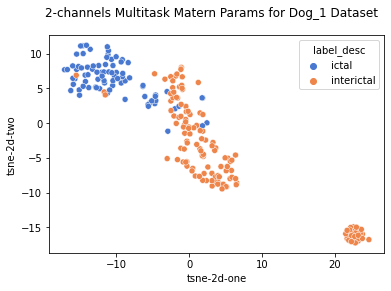

In [174]:
 # get results of multitask (pair) GP params MLE
requested_project_name = "inference/pairs"
requested_params = ['covar_module.data_covar_module.base_kernel.raw_lengthscale',
                    'covar_module.task_covar_module.covar_factor[0]',
                    'covar_module.task_covar_module.covar_factor[1]',
                    'covar_module.task_covar_module.raw_var[0]',
                    'covar_module.task_covar_module.raw_var[1]']

results_df = GPResultsCollector(requested_project_name, requested_params, n_pages=1).results_df

# get parameter values
X = results_df[requested_params].values

# calculate t-SNE values of parameters
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(X)

# add t-SNE results to results_df
results_df['tsne-2d-one'] = tsne_results[:, 0]
results_df['tsne-2d-two'] = tsne_results[:, 1]

# plot t-sne results
sns.scatterplot(data=results_df,
              x='tsne-2d-one', y='tsne-2d-two',
              # hue_order=hue_order,
              hue="label_desc", palette="muted", legend=True)
plt.suptitle("2-channels Multitask Matern Params for Dog_1 Dataset")
plt.show()

## Estimate interictal embeddings density

In [175]:
# fit a Gaussian Mixture Model with two components
gmm = mixture.GaussianMixture(n_components=2, covariance_type="full")
gmm.fit(X)

GaussianMixture(n_components=2)

## Load new data clip

In [176]:
# load dataset
dataset_dir = r"C:\Users\noam\Repositories\noamsgl\msc\data\seizure-detection\Dog_1"
dataset = DogDataset(dataset_dir)

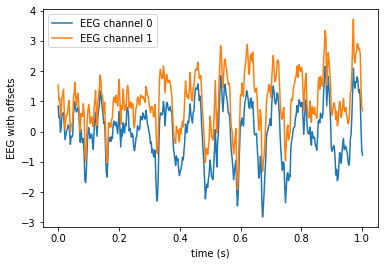

In [177]:
# set number of channels
num_channels = 2

# sample clip from dataset
train_x, train_y = dataset.sample_clip(num_channels, label_desc="ictal")

# plot clip with offsets
for i in range(train_y.size(-1)):
    plt.plot(train_x, train_y[..., i] + i, label=f"EEG channel {i}")
plt.legend()
plt.xlabel("time (s)")
plt.ylabel("EEG with offsets")
plt.show()

## Compute clip embedding
We embed the clip in the space of Gaussian process (GP) parameters.


In [178]:
torch.cuda.is_available()

True

In [179]:
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_channels)
model = multiChannelEEGGPModel(train_x, train_y, likelihood, num_channels)

In [ ]:
smoke_test = False
training_iterations = 2 if smoke_test else 1000

# move to GPU
assert torch.cuda.is_available()
train_x = train_x.cuda()
train_y = train_y.cuda()
model = model.cuda()
likelihood = likelihood.cuda()

# set model and likelihood to training mode
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

Iter 1/1000 - Loss: 1.390
Iter 2/1000 - Loss: 1.388
Iter 3/1000 - Loss: 1.387
Iter 4/1000 - Loss: 1.385
Iter 5/1000 - Loss: 1.383
Iter 6/1000 - Loss: 1.382
Iter 7/1000 - Loss: 1.380
Iter 8/1000 - Loss: 1.379
Iter 9/1000 - Loss: 1.378
Iter 10/1000 - Loss: 1.376
Iter 11/1000 - Loss: 1.375
Iter 12/1000 - Loss: 1.373
Iter 13/1000 - Loss: 1.372
Iter 14/1000 - Loss: 1.370
Iter 15/1000 - Loss: 1.369
Iter 16/1000 - Loss: 1.368
Iter 17/1000 - Loss: 1.366
Iter 18/1000 - Loss: 1.365
Iter 19/1000 - Loss: 1.364
Iter 20/1000 - Loss: 1.363
Iter 21/1000 - Loss: 1.361
Iter 22/1000 - Loss: 1.360
Iter 23/1000 - Loss: 1.359
Iter 24/1000 - Loss: 1.358
Iter 25/1000 - Loss: 1.357
Iter 26/1000 - Loss: 1.356
Iter 27/1000 - Loss: 1.354
Iter 28/1000 - Loss: 1.353
Iter 29/1000 - Loss: 1.352
Iter 30/1000 - Loss: 1.351
Iter 31/1000 - Loss: 1.350
Iter 32/1000 - Loss: 1.349
Iter 33/1000 - Loss: 1.348
Iter 34/1000 - Loss: 1.347
Iter 35/1000 - Loss: 1.346
Iter 36/1000 - Loss: 1.346
Iter 37/1000 - Loss: 1.345
Iter 38/10

In [ ]:
requested_params

In [ ]:
requested_params_new = ['covar_module.data_covar_module.raw_lengthscale',
                    'covar_module.task_covar_module.covar_factor[0]',
                    'covar_module.task_covar_module.covar_factor[1]',
                    'covar_module.task_covar_module.raw_var[0]',
                    'covar_module.task_covar_module.raw_var[1]']

In [ ]:
model.get_params_dict()

In [ ]:
params_df = pd.DataFrame(model.get_params_dict(), index=[0])

In [ ]:
embedding = params_df[requested_params_new].to_numpy()

## Compute ictality of clip

In [ ]:
# compute negative log likelihood of clip embedding
ictality = -gmm.score(embedding)
ictality

In [ ]:
# compute tail area probability (p-value) of clip
results_df["nll"] = results_df.apply(lambda row: -gmm.score(row[requested_params].to_frame().transpose()), axis=1)
results_df

In [ ]:
results_df.loc[results_df['label_desc'] == 'interictal', "nll"].plot(kind="hist", bins=100, label="all clips")
plt.vlines(ictality, 0, 10, colors="r", label="new clip")
plt.legend()
plt.title("Negative Log Likelihood Distribution of ictal clips")
p_value = (len(results_df[results_df["nll"] < ictality]))/(len(results_df))
print(f"{p_value=}")